In [3]:
library(limma)
library(reshape2)
library(Glimma)
library(ggplot2)
library(ggrepel)
# library(reshape)
library(edgeR)
library(gplots)
library(amap)
library(ggfortify)
library(data.table)
# library(Mus.musculus)


Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess



Attaching package: 'data.table'


The following objects are masked from 'package:reshape2':

    dcast, melt




In [4]:

# change this
setwd("C:\\Users\\Pete\\DSC180B-PROJECT")

In [5]:
file_url = 'https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE44639&format=file'            
raw_dir = "data/raw/"
temp_dir = "data/temp/"
file_name = 'GSE44639_RAW.tar'

In [6]:
ingest_data <- function(file_url, file_name, raw_dir, temp_dir) {
    if (!dir.exists(raw_dir)) {
        dir.create(raw_dir, recursive = TRUE)
    }
    out = paste(raw_dir, file_name, sep="")
    utils::download.file(file_url, destfile=out, mode="wb")
    utils::untar(out, exdir=temp_dir)
}

ingest_data(file_url, file_name, raw_dir, temp_dir)

In [7]:
read_all_files_in_dir_with_columns <- function(file_dir, required_columns) {
    files <- list.files(path=file_dir)
    
    all <- list()
    
    for (i in files) {
        fp <- paste(file_dir, i, sep='')
        seqdata <- read.delim(gzfile(fp), stringsAsFactors = FALSE)
        columns <- colnames(seqdata)
        
        has_unidentified_col <- FALSE
        
        # ignore samples with columns not present in required_columns
        for (c in columns) {
            if (!any(required_columns==c)) {
                has_unidentified_col <- TRUE
                break
            }
        }
        
        if (has_unidentified_col) {
            next
        }
        
        sampleName = strsplit(fp, "/")[[1]][3]
        sampleName = strsplit(sampleName, ".txt")[[1]][1]
        
        
        cellType = strsplit(fp, "_")[1]
        cellType = cellType[[1]][3]
        cellType = strsplit(cellType, ".txt")
        cellType = cellType[[1]][1]
        
        healthy <- !grepl("P", fp, fixed=TRUE)
        
        # add healthy column
        seqdata$healthy <- healthy
        seqdata$cellType <- cellType
        seqdata$sampleName <- sampleName
        
        if (length(all) == 0) {
            all <- seqdata
        } else {
            all <- rbind(all, seqdata)
        }
    }
    
    return(all)
}

required_columns <- list("miRNA", "Chromosome", "Position", "Strand", "Total.miRNA.reads", "RPM..reads.per.million.")
all <- read_all_files_in_dir_with_columns(temp_dir, required_columns)

In [10]:
head(all)

,miRNA,Chromosome,Position,Strand,Total.miRNA.reads,RPM..reads.per.million.,healthy,cellType,sampleName
,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<lgl>,<chr>,<chr>
1,hsa-miR-378c,chr10,132760851,-,7,1,TRUE,Naive,GSM1088200_M7_Naive
2,hsa-mir-1321,chrX,85090785,+,26,6,TRUE,Naive,GSM1088200_M7_Naive
3,hsa-miR-378d,chr8,94928250,-,2,1,TRUE,Naive,GSM1088200_M7_Naive
4,hsa-miR-2110,chr10,115933864,-,5,1,TRUE,Naive,GSM1088200_M7_Naive
5,hsa-mir-200b,chr1,1102484,+,2,1,TRUE,Naive,GSM1088200_M7_Naive
6,hsa-miR-125a-5p,chr19,52196507,+,7,1,TRUE,Naive,GSM1088200_M7_Naive


In [102]:
pivot_data <- function(countdata, value_column, groupNames, groupSizes) {
    ### pivot ingested miRNA counts data
    ### dataframe must have columns miRNA and sampleName
    # countdata - data with raw reads and from ingestion function
    # value_column - name of column with the reads
    # groupNames - list of group names
    # groupSizes - list of size of each group
    
    
    countdata <- dcast(countdata, miRNA ~ sampleName, value.var= value_column, fill= 0)
    rownames(countdata) <- countdata$miRNA
    countdata$miRNA <- NULL
    
    factoredGroups <- vector()
    for (i in 1:length(groupNames)) {
        curGroup <- rep(groupNames[i], groupSizes[i])
        factoredGroups <- c(factoredGroups, curGroup)
    }
    group <- factor(factoredGroups)
    toReturn <- list('countdata'=countdata, 'group'=group)
    return(toReturn)

}

filter_logcounts <- function(countdata, group) {
    countdata <- countdata + 0.5

    d <- DGEList(counts=countdata,group=group)

    # got values for filter from paper, Yuxia Zhang
    # filter all mirna with less than 1.5*(# of total samples) of counts across all samples. lowly expressing gene
    dd <- d[rowSums(d$counts) >= 1.5*ncol(d),]
    # multiply by million and divide by column library size to get RPM
    d<-1e+06 * dd$count/expandAsMatrix(d$samples$lib.size,dim(dd))
    # take the log RPM
    d<-log2(d)
    return(d)
}

In [110]:
# pret1 <- all[all$healthy == FALSE,] 
# naive <- all[all$cellType == 'Naive',] 
rTreg <- all[all$cellType == 'rTreg',] 

groupNames <- c("healthyrTreg", "pret1rTreg")
groupSizes <- c(8,7)
dataAndGroupList <- pivot_data(rTreg, "Total.miRNA.reads", groupNames, groupSizes)
df <- filter_logcounts(dataAndGroupList$countdata, dataAndGroupList$group)

Warning message in dcast(countdata, miRNA ~ sampleName, value.var = value_column, :
"The dcast generic in data.table has been passed a data.frame and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(countdata). In the next version, this warning will become an error."


In [148]:
absF <- function(df, groupSize1, groupSize2) {
    # calculate absF, stat for between-group variability vs within-group. used for volcano plot
    F<-data.frame(nrow(df))
    # NAIVE
    x<-data.frame(nrow(df),2) # for calculating fold change later
    total_groups <- groupSize1+groupSize2
    for (i in 1:nrow(df)) {
        a<-groupSize1*abs(mean(df[i,1:groupSize1])-mean(df[i,1:total_groups]))+groupSize2*abs(mean(df[i,(groupSize1+1):total_groups])-mean(df[i,1:total_groups]))
        bb = 0
        for (j in 1:groupSize1) {
            b<-abs(df[i,j]-mean(df[i,1:groupSize1]))
            bb = bb +b
        }

        for (j in (groupSize1+1):total_groups) {
            b<-abs(df[i,j]-mean(df[i,(groupSize1+1):total_groups]))
            bb = bb +b
        }

        F[i]<-12*a/bb # 12 is scalar from the paper/ Yuxia Zhang


        # X contains the mean of the logRPM of each group.
        x[i,2]<-mean(df[i,1:groupSize1])
        x[i,1]<-mean(df[i,(groupSize1+1):total_groups])

    }
    names(F)<-rownames(df)
    rownames(x)<-rownames(df)
#     absFOver9.6<-length(F[,F>9.6]) # 9.6 chosen from paper. corresponds to less than 1% false discovery rate in limma package
    return(list(FVal_df=F, miRNA_means=x))
}
    


In [165]:
absFScores <- absF(df, 8, 7)
FVal_df<- absFScores$FVal_df
miRNA_means <- absFScores$miRNA_means
FVal_df

hsa-let-7a,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7a*,hsa-let-7b,hsa-let-7b*,hsa-let-7c,hsa-let-7d,hsa-let-7d*,...,hsa-mir-942,hsa-miR-942,hsa-mir-95,hsa-miR-95,hsa-miR-96,hsa-mir-98,hsa-miR-98,hsa-miR-99a,hsa-miR-99b,hsa-miR-99b*
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.554506,1.250739,0.3868561,1.715975,3.281919,7.019244,4.543778,9.367175,2.976338,0.1341111,...,1.026727,2.841354,5.493217,3.112655,3.567207,5.04164,5.817443,4.012225,5.538715,2.534293


In [166]:
volcano_plot <- function(df, miRNA_means, FVal_df, Title) {
    absFOver9.6<-length(FVal_df[,FVal_df>9.6])
    # f <- x[names(-sort(-F))[1:166],1]-x[names(-sort(-F))[1:166],2]

    f <- miRNA_means[names(-sort(-F))[1:absFOver9.6],1]-miRNA_means[names(-sort(-F))[1:absFOver9.6],2] # fold change on the mirna with ABS F>9.6

    names(f)<-names(-sort(-absFOver9.6))[1:absFOver9.6]
    # -sort(-f)

    # filter by abs(logFC) >= 1
    id<-c(names(f[f>=1]),names(f[-f>=1]))
    # length(id)

    # calculate logFC again for mirna which meet filters, might be redundant
    y<-df[id,]
    de<-rownames(miRNA_means)%in%id
    f<-c(miRNA_means[de,1]-miRNA_means[de,2])

    saved_mirna<- rownames(miRNA_means[de,])
    names(f)<- saved_mirna
    f # gives us the filtered names of mirna with absF > 9.6 with abs(logFC) >=1.


    fval<-as.numeric(FVal_df)
    fold<-as.numeric(miRNA_means[,1]-miRNA_means[,2])

    volcanodf<-data.frame(fold,fval)


    ## 20 highest F-values labeled
    numToLabel = 20

    ggplot(volcanodf, aes(fold,fval)) +
        geom_point(color='red',alpha = 0.5) + 
        geom_text_repel(aes(fold,fval),segment.size = 1, min.segment.length=0.5, box.padding=1,
        segment.alpha = .8,
        force = 1,segment.color = "grey50",label=as.character(ifelse(FVal_df >= as.numeric(-sort(-FVal_df)[numToLabel]), colnames(FVal_df), NA)),hjust=0,vjust=0) +
        labs(y= "F-Value", x = "Log2 Fold Change") +
        ggtitle(Title) + theme(text = element_text(size = 13))   

}

Warning message:
"Removed 499 rows containing missing values (geom_text_repel)."


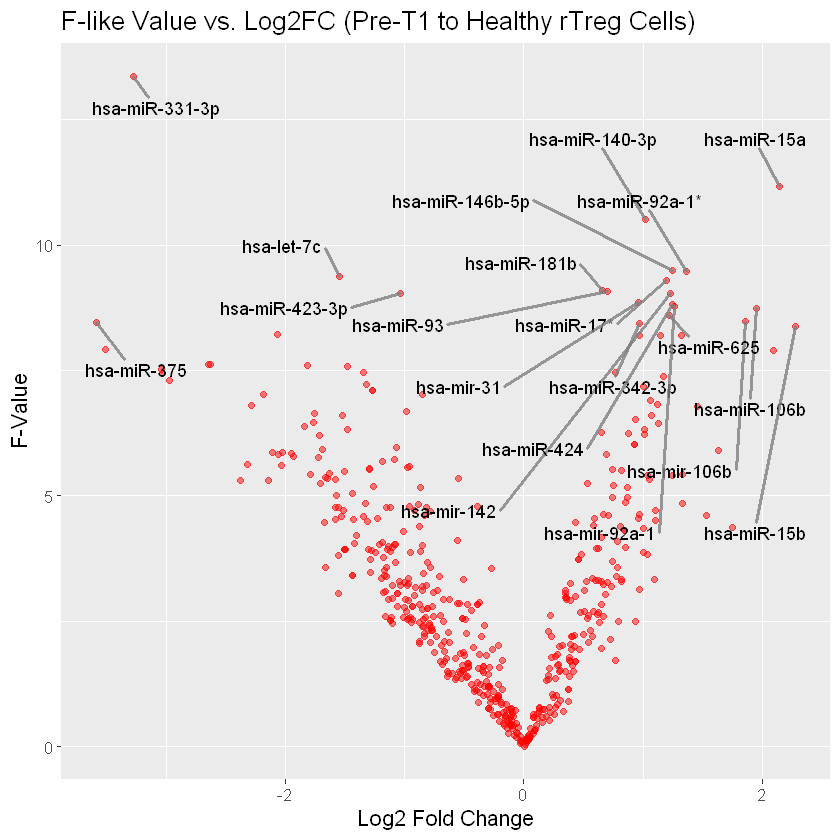

In [167]:
volcano_plot(df, miRNA_means, FVal_df, "F-like Value vs. Log2FC (Pre-T1 to Healthy rTreg Cells)")